# package and data loading

In [1]:
#packages for data handling
import anndata as ad
import pandas as pd

#scanpy for downsampling
import scanpy as sc

#numpy for computations
import numpy as np
np.random.seed(42)

#matplotlib for visualization
import matplotlib.pyplot as plt

In [2]:
#scRNA-seq h5ad
adata_cells_raw = ad.read_h5ad('../data/daniocell2023_gastrulation.cells.h5ad')
adata_cells_raw.X = adata_cells_raw.X.toarray()
print(f"Full: {adata_cells_raw.n_obs} cells, {adata_cells_raw.n_vars} genes")

#metacells h5ad
adata_mc = ad.read_h5ad('../data/daniocell2023_gastrulation.metacells.h5ad')
print(f"Full: {adata_mc.n_obs} cells, {adata_mc.n_vars} genes")

selected_genes = adata_mc.var['selected_gene']

#scVI clustering data
df_cell_to_cluster_scvi = pd.read_csv('../data/cells_cluster_data.csv')

Full: 35705 cells, 28833 genes
Full: 1010 cells, 28833 genes


# data preperation

In [3]:
scmat_dense = adata_cells_raw.X
scmat_dense = scmat_dense.transpose()
scmat_dense = pd.DataFrame(scmat_dense, 
                           index=adata_cells_raw.var_names.to_list(), 
                           columns=adata_cells_raw.obs_names)
for n in np.quantile(np.sum(scmat_dense,axis=0),q=[0,.25,.5,.75,1]):
    print(n)

1000.0
2818.0
4313.0
6511.0
14024.0


## downsampling, normalization scRNA-seq data

### for each cell: downsample counts to 2800

In [4]:
adata_cells = adata_cells_raw.copy()
sc.pp.downsample_counts(adata_cells, 
                        counts_per_cell=2800, 
                        random_state=42)

### remove cells with less than 2400 counts

In [5]:
tmp_sum = np.sum(adata_cells.X, axis=1)
mask = [(n == 2800) for n in tmp_sum]
print(f'removing {mask.count(False)} cells with less than 2800 UMIs')

scmat_ds = (adata_cells.X)[mask]
scmat_ds = scmat_ds.transpose()
scmat_ds = pd.DataFrame(scmat_ds, index=adata_cells.var_names.to_list(), columns=adata_cells[mask].obs_names)

removing 8793 cells with less than 2800 UMIs


### normalize downsampled raw gene expression (log2)

In [6]:
log2_scmat_ds = np.log2(scmat_ds + 1)
cells_downsamp = log2_scmat_ds.columns

## normalization (Metacells)

### aggregate metacells (sum up counts of cells with the same metacell)

In [7]:
tmp = pd.DataFrame(scmat_dense.to_numpy(), 
                   index=adata_cells.var_names.to_list(), 
                   columns=adata_cells.obs['metacell_name'])
eg_m1 = tmp.groupby(tmp.columns,axis=1).sum()

/tmp/ipykernel_589586/2857165574.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  eg_m1 = tmp.groupby(tmp.columns,axis=1).sum()
/tmp/ipykernel_589586/2857165574.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eg_m1 = tmp.groupby(tmp.columns,axis=1).sum()


### copy metacell gene expression to every corresponding cell, remove raw counts from each cell (to account for self correlation)

In [8]:
egm1_minus_cell = eg_m1[adata_cells.obs['metacell_name']] - scmat_dense.to_numpy()

### normalize counts of each cell: count[cell_i, gene_i] / totalcount[cell_i]

In [9]:
egm1_minus_cell = egm1_minus_cell / (egm1_minus_cell).sum().array

### normalize with log2

In [10]:
reg = 5e-5
legm1_minus_cell = np.log2(egm1_minus_cell + reg)

In [11]:
legm1_minus_cell = pd.DataFrame(legm1_minus_cell.to_numpy(), index=adata_cells.var_names.to_list(), columns=adata_cells.obs_names)

## normalization scvi cluster

### aggregate scvi cluster (sum up counts of cells with the same cluster)

In [12]:
tmp = pd.DataFrame(scmat_dense.to_numpy(), 
                   index=adata_cells.var_names.to_list(), 
                   columns=df_cell_to_cluster_scvi['predicted_cluster'])
eg_m2 = tmp.groupby(tmp.columns,axis=1).sum()

/tmp/ipykernel_589586/3690303281.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  eg_m2 = tmp.groupby(tmp.columns,axis=1).sum()


### copy cluster gene expression to every cell, remove raw counts from each cell (to correct for self correlation)

In [13]:
egm2_minus_cell = eg_m2[df_cell_to_cluster_scvi['predicted_cluster']] - scmat_dense.to_numpy()

### normalize counts of each cell: count[cell_i, gene_i] / totalcount[cell_i]

In [14]:
egm2_minus_cell = egm2_minus_cell / (egm2_minus_cell).sum().array

### normalize with log2

In [15]:
legm2_minus_cell = np.log2(egm2_minus_cell + reg)
legm2_minus_cell = pd.DataFrame(legm2_minus_cell.to_numpy(), 
                                index=adata_cells.var_names.to_list(), 
                                columns=df_cell_to_cluster_scvi['cell'])

# compare clustering methods

## calculate correlation for each (selected) gene: 
- [norm. downsampled sc gene expr.] vs. [norm. downsampled metacell gene expr.]
- [norm. downsampled sc gene expr.] vs. [norm. downsampled scVIcluster gene expr.]

In [16]:
def gene_expr_lst(df, gene, cell=None):
    if cell is None:
        return(df.loc[gene].to_list())
    else:
        return(df.loc[gene,cell].to_list())

for every selected gene: correlation (log2_scmat_ds[selected_gene] vs. legm{1,2}_minus_cell[selected_gene])

In [17]:
selected_genes_mask = selected_genes
selected_genes_list = selected_genes[selected_genes == 1].index.to_list()
sc_mc_cor1 = np.zeros(len(selected_genes_list))
sc_mc_cor2 = np.zeros(len(selected_genes_list))
index = 0
for gene in selected_genes_list:
    sc_mc_cor1[index] = np.corrcoef(gene_expr_lst(log2_scmat_ds,gene), gene_expr_lst(legm1_minus_cell,gene,cells_downsamp))[0,1]
    sc_mc_cor2[index] = np.corrcoef(gene_expr_lst(log2_scmat_ds,gene), gene_expr_lst(legm2_minus_cell,gene,cells_downsamp))[0,1]
    index += 1

## visualization mc, scVI comparison

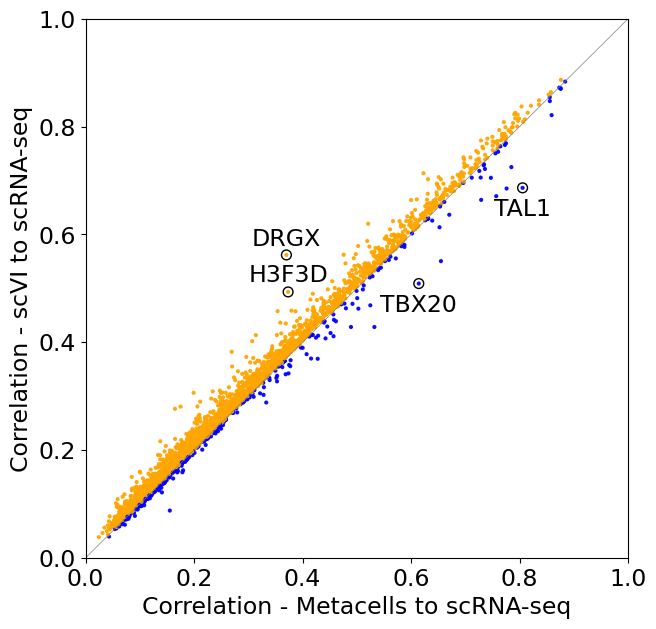

In [18]:
plt.figure(figsize=(7,7))

colors = np.where(sc_mc_cor1 > sc_mc_cor2, 'blue', 'orange')

plt.scatter(sc_mc_cor1, sc_mc_cor2, 
                 s=4, 
                 color=colors, 
                 alpha=.9)
plt.axline((0.1,0.1),(.9,.9), 
           linewidth=.5, 
           color='grey')

plt.xlabel('Correlation - Metacells to scRNA-seq', fontsize=17)
plt.ylabel('Correlation - scVI to scRNA-seq', fontsize=17)

indices_dist = np.argsort(sc_mc_cor1 - sc_mc_cor2)
for i in indices_dist[:2]:
    plt.annotate(selected_genes_list[i], (sc_mc_cor1[i], sc_mc_cor2[i]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=17)
    plt.scatter(sc_mc_cor1[i], sc_mc_cor2[i], color='none', edgecolors='black', s=50, linewidth=1)

for i in indices_dist[-2:]:
    plt.annotate(selected_genes_list[i], (sc_mc_cor1[i], sc_mc_cor2[i]), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=17)
    plt.scatter(sc_mc_cor1[i], sc_mc_cor2[i], color='none', edgecolors='black', s=50, linewidth=1)

plt.xticks(np.arange(0,1.2, step=.2), fontsize=17)
plt.xlim(0,1)
plt.yticks(np.arange(0,1.2, step=.2), fontsize=17)
plt.ylim(0,1)

plt.savefig('../figures/gene_expression_comparison/correlation_mc_scvi.png', 
            dpi=300, 
            bbox_inches='tight')
plt.show()

### some stats

In [19]:
print(f'#points below diagonal: {np.unique(colors, return_counts=True)[1][0]}')
print(f'#points above diagonal: {np.unique(colors, return_counts=True)[1][1]}')
print('')

for i in indices_dist[:2]:
    print(f'Gene {selected_genes_list[i]} with correlations: ({sc_mc_cor1[i]:.4f},{sc_mc_cor2[i]:.4f}); delta={np.abs(sc_mc_cor1[i] - sc_mc_cor2[i]):.4f}')
for i in indices_dist[-2:]:
    print(f'Gene {selected_genes_list[i]} with correlations: ({sc_mc_cor1[i]:.4f},{sc_mc_cor2[i]:.4f}); delta={np.abs(sc_mc_cor1[i] - sc_mc_cor2[i]):.4f}')
print('')

differences = (sc_mc_cor2 - sc_mc_cor1) / np.sqrt(2)
print(f'below diagonal mean distance: {(-1)*np.mean(differences[differences < 0]):.4f}')
print(f'above diagonal mean distance: {np.mean(differences[differences > 0]):.4f}')

#points below diagonal: 301
#points above diagonal: 3141

Gene DRGX with correlations: (0.3700,0.5617); delta=0.1917
Gene H3F3D with correlations: (0.3732,0.4931); delta=0.1199
Gene TBX20 with correlations: (0.6141,0.5087); delta=0.1054
Gene TAL1 with correlations: (0.8054,0.6862); delta=0.1192

below diagonal mean distance: 0.0066
above diagonal mean distance: 0.0105


### histogram of distances to x=y

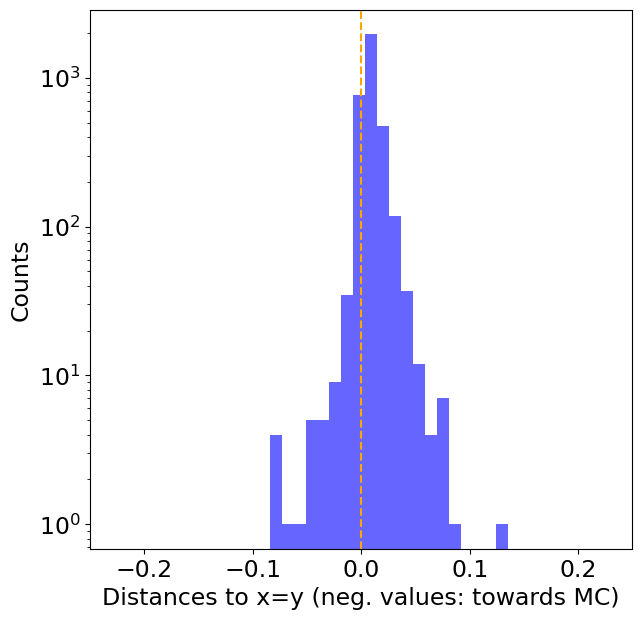

In [20]:
plt.figure(figsize=(7,7))

plt.hist(np.sort(differences), 
         log=1, 
         bins=20, 
         alpha=.6, 
         color='blue')
plt.axvline(x=0,
            color='orange',
            linestyle='dashed')

plt.xlabel('Distances to x=y (neg. values: towards MC)', fontsize=17)

plt.xticks(np.arange(-0.2,0.3,.1), fontsize=17)
plt.xlim(-0.25,0.25)
plt.yticks(fontsize=17)
plt.ylabel('Counts', fontsize=17)

plt.savefig('../figures/gene_expression_comparison/distances_mc_scvi_compare.png',
            dpi=300,
            bbox_inches='tight')
plt.show()